In [1]:
import os, sys, inspect
from pathlib import Path

current_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score

In [4]:
# file 
data_path = os.path.join(parent_dir, 'examples/test_data')
file_name = 'adult.csv'
file_path = os.path.join(data_path, file_name)

In [5]:
# Load the dataset
data = pd.read_csv(file_path)

# Handle missing values
data = data.dropna()

In [6]:
print(data.shape)
data.head()

(30162, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0


In [9]:
# Split features and target variable
X = data.drop('income', axis=1)
y = data['income']

# Perform categorical encoding
categorical_features = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
encoder = OrdinalEncoder(cols=categorical_features)
encoded_features = encoder.fit_transform(X[categorical_features])

# Concatenate encoded features with numerical features
X_encoded = pd.concat([X.drop(categorical_features, axis=1), pd.DataFrame(encoded_features)], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [10]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
# Make predictions on the testing set
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8476711420520471
Confusion Matrix:
[[4192  341]
 [ 578  922]]


In [12]:
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_test, y_pred),3)))

Balanced Accuracy: 0.77


## Veritas model

In [13]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer
from veritastool.usecases.predictive_underwriting import PredictiveUnderwriting

/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for 

In [34]:
encoding_mapping = encoder.mapping

In [63]:
X_train.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country
19841,35,61343,10,0,0,45,1,3,5,7,5,1,2,1
24329,50,306707,9,0,0,12,3,1,4,5,2,2,1,1
10002,43,271665,9,0,0,45,4,1,5,7,5,1,2,1
25682,23,481175,10,0,0,24,1,3,4,1,3,4,2,25
13800,30,287986,10,0,0,40,1,3,4,12,1,1,2,1


In [40]:
p_grp = {'race': [1]} # Include intersectional fairness
up_grp = {'race': [2, 3, 5]}

In [43]:
model_name = "pred_underwriting"
model_type = "classification"

In [53]:
X_train.shape

(24129, 14)

In [60]:
#Create Model Container 
container = ModelContainer(p_grp=p_grp, model_type=model_type, model_name=model_name, y_pred=y_pred, y_prob=y_prob, \
                           y_train=y_train, x_train=X_train, y_true=y_test, \
                           x_test=X_test, model_object=rf_model, up_grp=up_grp, pos_label=[1.0])

In [64]:
pred_underwriting_obj= PredictiveUnderwriting(model_params = [container], fair_threshold = 80, fair_concern = "inclusive", \
                                        fair_priority = "benefit", fair_impact = "normal", fair_metric_type='ratio',\
                                        tran_row_num=[1,2,3], tran_max_sample = 1000, tran_max_display = 10, \
                                        tran_pdp_feature = ['age','hours.per.week'])

In [65]:
pred_underwriting_obj.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          24.863%
	neg_label                                                          75.137%


Performance Metrics
	Selection Rate                                             0.209 +/- 0.009
	Accuracy                                                   0.848 +/- 0.009
	Balanced Accuracy                                          0.770 +/- 0.013
	Recall                                                     0.615 +/- 0.025
	Precision                                                  0.730 +/- 0.019
	F1 Score                                                   0.667 +/- 0.019
	True Negative Rate                                         0.925 +/- 0.006
	False Negative Rate                                        0.385 +/- 0.025
	Negative Predictive Value                                  0.879 +/- 0.010
	ROC AUC Score                                              0.900 +/- 0.008
	Log-loss                                     

In [66]:
pred_underwriting_obj.tradeoff()

Tradeoff:   0%|          


------------------------------- 1. race  -------------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.700
		Best balanced_acc*                                0.798
	 Separated Thresholds
		Privileged Threshold                              0.300
		Unprivileged Threshold                            0.300
		Best balanced_acc*                                0.811
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.447
		Unprivileged Threshold                            0.301
		Best balanced_acc*                                0.791
		*estimated by approximation, subject to the resolution of mesh grid



In [67]:
pred_underwriting_obj.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Race-------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |balanced_acc             |fpr_ratio                |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|race                          |-0.001                   |0.182                    |unfair to unfair (+)|Examine Further   |
----------------------------------------------------------------------------------------------------------------------------



Correlation analysis :   0%|          

Permutation explainer: 1004it [05:20,  3.04it/s]                                                                        



Partial correlation matrix (Most correlated features for race):


,native.country,education.num,race,fnlwgt
native.country,1.000000,0.252862,0.658547,0.000000
education.num,0.252862,1.000000,0.191126,0.061646
race,0.658547,0.191126,1.000000,0.160021
fnlwgt,0.000000,0.061646,0.160021,1.000000


* No surrogate detected based on correlation analysis (threshold=0.7).


## Transperancy

Running transparency for model 1        done      


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


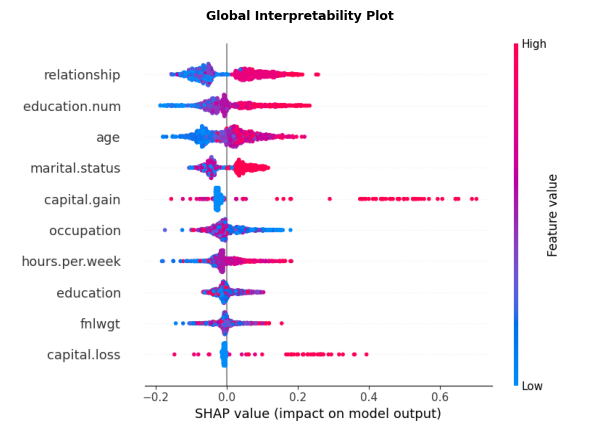

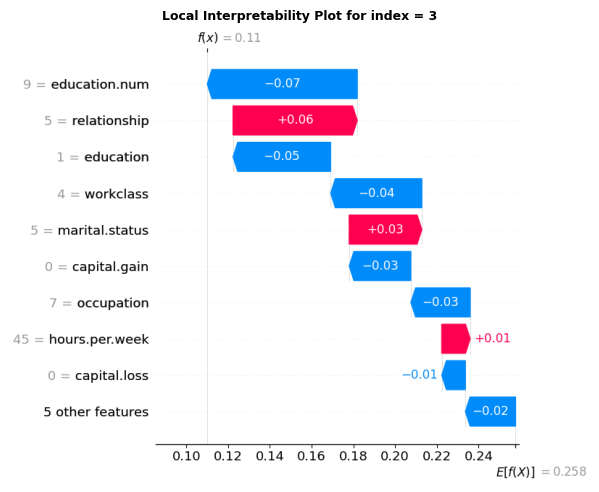

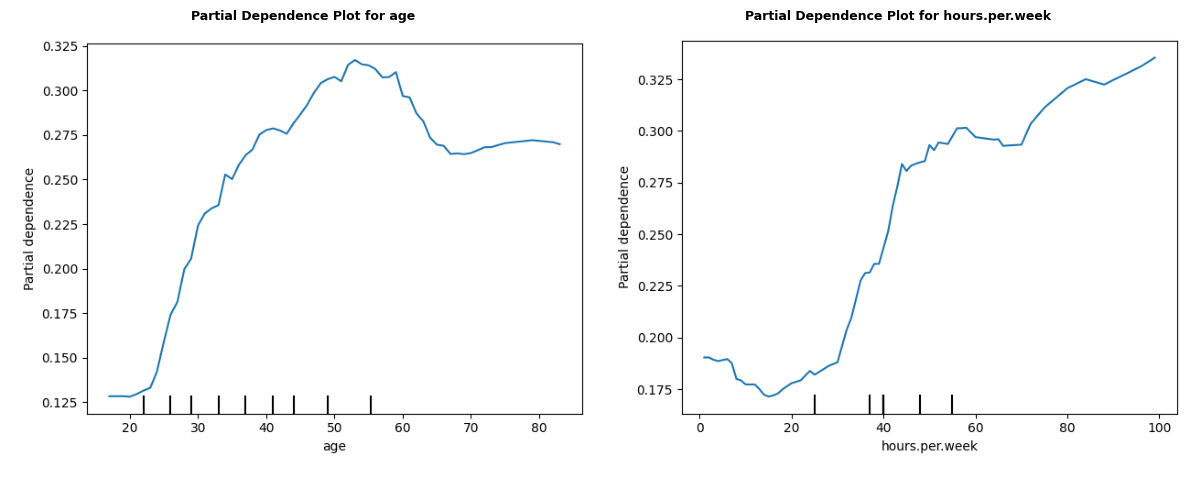

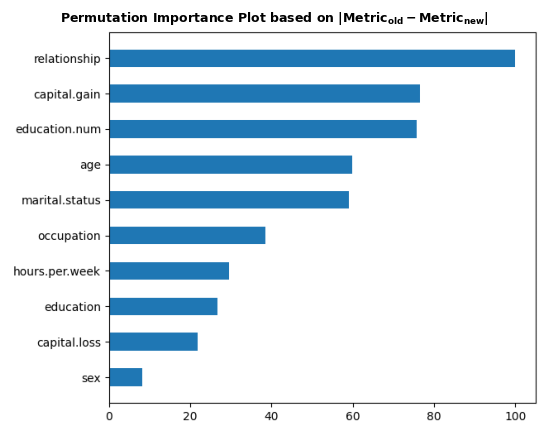

In [68]:
pred_underwriting_obj.explain()

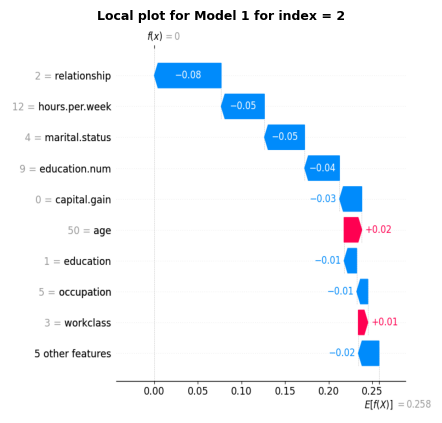

In [70]:
# get the local interpretability plot for specific row index and model
pred_underwriting_obj.explain(local_row_num = 2)

In [71]:
pred_underwriting_obj.compile()

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            done      
     performance dynamics               done      
     individual fairness                done      
Running tradeoff                        done      
Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               done      
Running transparency for model 1        done      
Generating model artifact               done
Saved model artifact to model_artifact_pred_underwriting_20230703_2310.json


## Bias mitigation

Root cause analysis:   0%|          



                              Top 10 contributors towards bias for class '1'      
                         Measured by SHAP-based Demographic Parity on 1003 samples




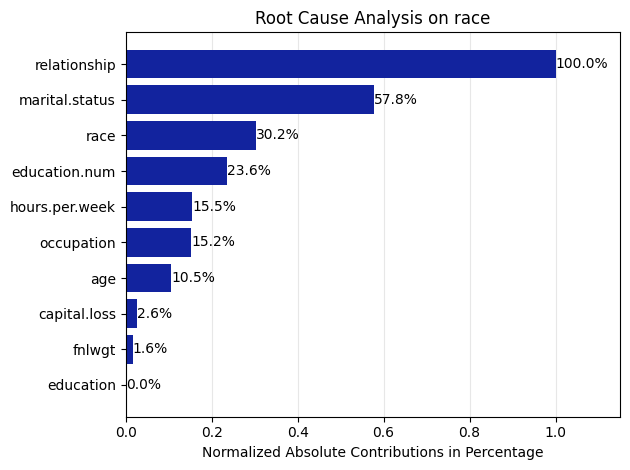

In [72]:
pred_underwriting_obj.rootcause(p_var=['race'])

In [73]:
mitigated = pred_underwriting_obj.mitigate(p_var=['race'], method=['threshold', 'reweigh', 'correlate'])

Bias mitigation :   0%|          


*Effective input for p_var = ['race']

                                Threshold tuning                                

--------------------------------------------------------------------------------
|Protected variable            |Privileged             |Unprivileged           |
--------------------------------------------------------------------------------
|race                          |0.447                  |0.301                  |
--------------------------------------------------------------------------------


                                   Reweighing                                   

--------------------------------------------------------------------------------
|race                          |Label                  |Weight                 |
--------------------------------------------------------------------------------
|1                             |0                      |1.021                  |
-----------------------------------------------------------------

In [74]:
# y_pred can be used to reinitialise the model container and rerun fairness assessment
y_pred_gender_mitigated = mitigated['threshold'][0]

In [75]:
# sample_weights can be used to reinitialise the model container and rerun fairness assessment
sample_weights_mitigated = mitigated['reweigh'][0]

In [76]:
# x_train, x_test can be used to reinitialise the model container and rerun fairness assessment
x_train_mitigated = mitigated['correlate'][0]
x_test_mitigated = mitigated['correlate'][1]

In [83]:
# for illustration, a new dataset is being sampled from x_test and y_true
indices = np.random.choice(X_test.index, size=50, replace=False)
x_test_sample = X_test.loc[indices].reset_index(drop=True)
y_true_sample = y_test[indices]
_, _, beta = mitigated['correlate']

In [84]:
transform_mitigated = pred_underwriting_obj.mitigate(p_var=['gender'], method=['correlate'], cr_alpha=0.9, cr_beta=beta, 
                                                     transform_x=x_test_sample)

Bias mitigation :   0%|          


*Effective input for p_var = ['race']

                              Correlation Removal                               

Transforming dataset based on provided and corr_alpha and corr_beta.



In [85]:
# debiased transform_x
transform_mitigated['correlate'][0].head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country
0,49.812901,40212.656619,9.965494,-38.885954,-3.358862,39.828231,0.993719,2.99851,1.989305,6.998537,0.971067,NaN,0.987278,1.303457
1,59.812901,44504.656619,13.965494,-38.885954,-3.358862,9.828231,3.993719,7.99851,1.989305,2.998537,1.971067,NaN,0.987278,1.303457
2,33.812901,208374.656619,11.965494,-38.885954,-3.358862,49.828231,0.993719,12.99851,1.989305,6.998537,0.971067,NaN,1.987278,1.303457
3,43.812901,193471.656619,12.965494,-38.885954,-3.358862,39.828231,0.993719,6.99851,4.989305,0.998537,4.971067,NaN,1.987278,1.303457
4,39.812901,81750.656619,12.965494,-38.885954,-3.358862,39.828231,0.993719,6.99851,3.989305,4.998537,0.971067,NaN,1.987278,1.303457


In [90]:
class MitigateWrapper(ModelWrapper):

    def __init__(self, model_obj, th, classes=[0, 1]):
        self.model_obj = model_obj
        self.classes_ = classes        
        self.th = th

    def fit(self, X, y):
            
        self.model_obj.fit(X, y)
  
    
    def predict(self, x_test):
                
        test_probs = self.model_obj.predict_proba(x_test)[:, 1] 
                        
        # Using bias mitigation thresholds
        
        test_preds = np.where(test_probs > self.th, 1, 0)
        
        return test_preds
    
    
    def predict_proba(self, x_test):
        
        return self.model_obj.predict_proba(x_test)
    
    
def get_row_threshold(X, column, groups, thresholds):
    th = np.zeros(len(X), dtype=float)
    
    for g, t in zip(groups, thresholds):
        group_mask = X[column] == g
        th[group_mask] = t
    return th

th = get_row_threshold(X_test,"race", [1, 2, 3, 4, 5],[0.447, 0.301, 0.301, 0.301, 0.301])

In [93]:
rfc_untrained = RandomForestClassifier(random_state=33)
model_obj = MitigateWrapper(rfc_untrained, th)

In [95]:
model_obj.fit(X_train, y_train)

In [101]:
mitg_y_pred = model_obj.predict(X_test)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_test, mitg_y_pred),3)))

mitg_y_prob = model_obj.predict_proba(X_test)[:, 1] 

Balanced Accuracy: 0.786


In [ ]:
container = ModelContainer(p_grp=p_grp, model_type=model_type, model_name=model_name, y_pred=y_pred, y_prob=y_prob, \
                           y_train=y_train, x_train=X_train, y_true=y_test, \
                           x_test=X_test, model_object=rf_model, up_grp=up_grp, pos_label=[1.0])

In [106]:
container_mitg = ModelContainer(model_type=model_type, model_name=model_name, y_pred=mitg_y_pred, y_prob=mitg_y_prob, 
                                y_train=y_train, y_true=y_test, p_grp=p_grp, x_train=X_train, x_test=X_test, 
                                model_object=model_obj, up_grp=up_grp)

pred_underwriting_obj_mitg = PredictiveUnderwriting(model_params = [container_mitg], fair_threshold = 80, fair_concern = "inclusive", \
                                        fair_priority = "benefit", fair_impact = "normal", fair_metric_type='ratio',\
                                               tran_row_num=[1,2,3], tran_max_sample = 1000, tran_max_display = 10, \
                                                      tran_pdp_feature = ['age','hours.per.week'])

pred_underwriting_obj_mitg.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          24.863%
	neg_label                                                          75.137%


Performance Metrics
	Selection Rate                                             0.248 +/- 0.014
	Accuracy                                                   0.840 +/- 0.009
	Balanced Accuracy                                          0.786 +/- 0.011
	Recall                                                     0.679 +/- 0.022
	Precision                                                  0.679 +/- 0.024
	F1 Score                                                   0.679 +/- 0.017
	True Negative Rate                                         0.894 +/- 0.011
	False Negative Rate                                        0.321 +/- 0.022
	Negative Predictive Value                                  0.894 +/- 0.007
	ROC AUC Score                                              0.899 +/- 0.008
	Log-loss                                     

In [107]:
#Call evaluate not just balanced accuracy
pred_underwriting_obj_mitg.compile(disable=['evaluate>perf_dynamic|calibration_curve|individual_fair', \
                                      'feature_importance>correlation', 'explain'])

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            done      
     performance dynamics               done      
     individual fairness                done      


Tradeoff:   0%|          


Running tradeoff                        done      


Feature importance:   0%|          


Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               skipped   
Running transparency                    skipped   
Generating model artifact               done
Saved model artifact to model_artifact_pred_underwriting_20230703_2320.json
